In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Reiter cellular model for snow crystal growth

The value at cell $i$ and time $n$ is given by

$$
u^n_i = d^n_i + g^n_i 
$$

The diffusion term and growth term is given by

$$
g^n_i = ( u^{n-1}_i + \gamma ) \delta^{n-1}_i, \qquad d^n_i = \tfrac{1}{2} u^{n-1}_i (1-\delta^{n-1}_i) + \tfrac{1}{12} \sum_{j\in nn(i)} u^{n-1}_j (1-\delta^{n-1}_j)
$$

where $nn(i)$ denote the set of nearest neighbours of cell $i$.

In [2]:
class Cell:
    
    def __init__(self, i, j, u):
        self.i = i
        self.j = j
        self.u = u
        self.isIce = False
        self.isReceptive = False
        
    def isI(self):
        return self.u >= 1.0
    
    def isR(self):
        if self.isIce:
            return True
        for n in self.neighbours:
            if n.isIce:
                return True
        return False
        
    def diffuse(self):
        d = 0.0
        for n in self.neighbours:
            d = d + n.u * (1-n.isReceptive)
        d = d / 12.0 + 0.5 * self.u * (1-self.isReceptive)
        return d
    
    def grow(self, gamma):
        return ( self.u + gamma ) * self.isReceptive


In [3]:
def getU(cells):
    N2 = len(cells)
    U = np.zeros(N2)
    for i in range(N2):
        U[i] = cells[i].u
    return U

def show(X, Y, cells, size=13):
    U = getU(cells)
    plt.figure(figsize=(size, size))
    sns.scatterplot(x=X, y=Y, hue=U, s=40)
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    
def showIce(X, Y, cells, size=13):
    U = getU(cells)
    isIce = (U >= 1.0)
    plt.figure(figsize=(size, size))
    sns.scatterplot(x=X[isIce], y=Y[isIce], hue=U[isIce], s=3)
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)

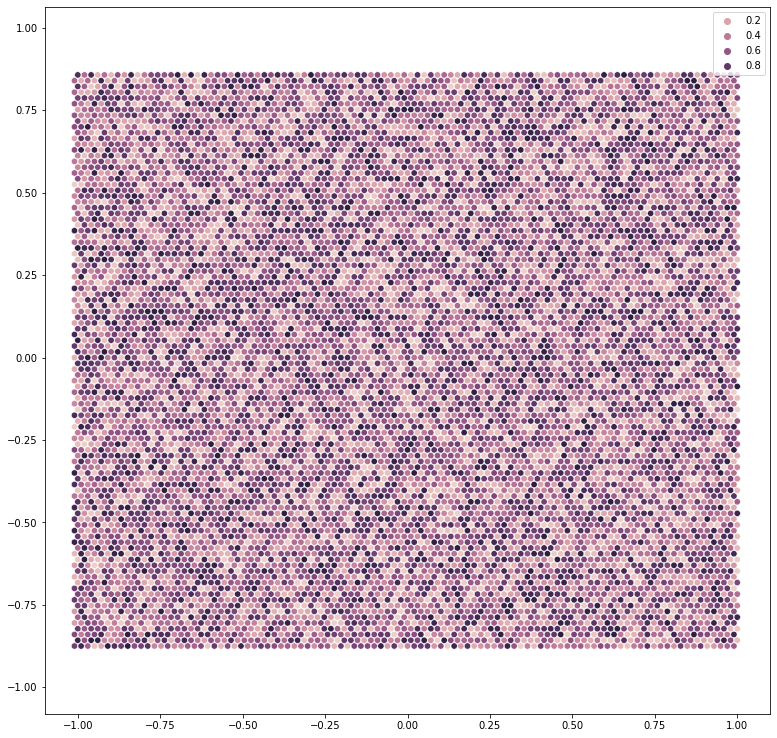

In [4]:
# generate mesh
L = 50
N = 2*L
N2 = N*N

# grid position
x = np.arange(-L, L, 1.0)
y = np.arange(-L, L, 1.0)
X, Y = np.meshgrid(x, y)

# align hexagon
X[1::2,:] = X[1::2,:] + 0.5
X = X * math.sqrt(3)
Y = Y * 1.5

# rescale grid
xmax = X.max()
X = X/xmax
Y = Y/xmax

# reshape
X = X.reshape(-1)
Y = Y.reshape(-1)

# create cells
cells = []
for i in range(N):
    for j in range(N):
        cells.append( Cell(i, j, random.random()) )

# neighbour list
for i in range(N):
    for j in range(N):

        # periodic boundary condition
        im1 = N-1 if i == 0 else i-1
        ip1 = 0 if i == N-1 else i+1
        jm1 = N-1 if j == 0 else j-1
        jp1 = 0 if j == N-1 else j+1

        u3 = cells[i*N+jm1]
        u4 = cells[i*N+jp1]

        if i % 2 == 0:
            jp1 = j
        else:
            jm1 = j

        u1 = cells[im1*N+jm1]
        u2 = cells[im1*N+jp1]
        u5 = cells[ip1*N+jm1]
        u6 = cells[ip1*N+jp1]

        cells[i*N+j].neighbours = [u1, u2, u3, u4, u5, u6]

show(X, Y, cells)


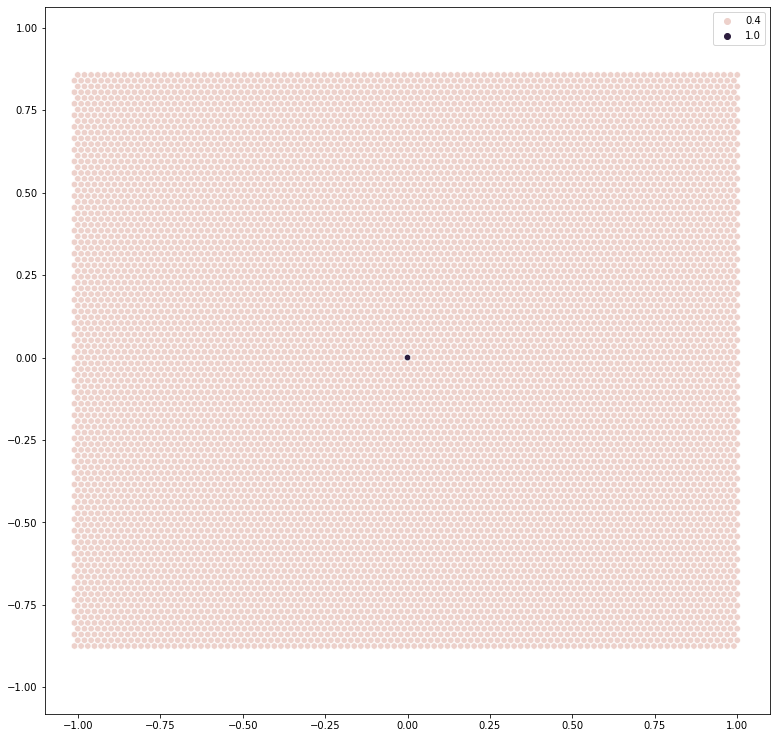

In [5]:
# numerical parameters
beta = 0.4         # background level
gamma = 0.01      # growth rate

# initial condition
for i in range(N2):
    cells[i].u = beta 
cells[L*N+L].u = 1.0
# for n in cells[L*N+L].neighbours:
#     n.u = 1.0

show(X, Y, cells)

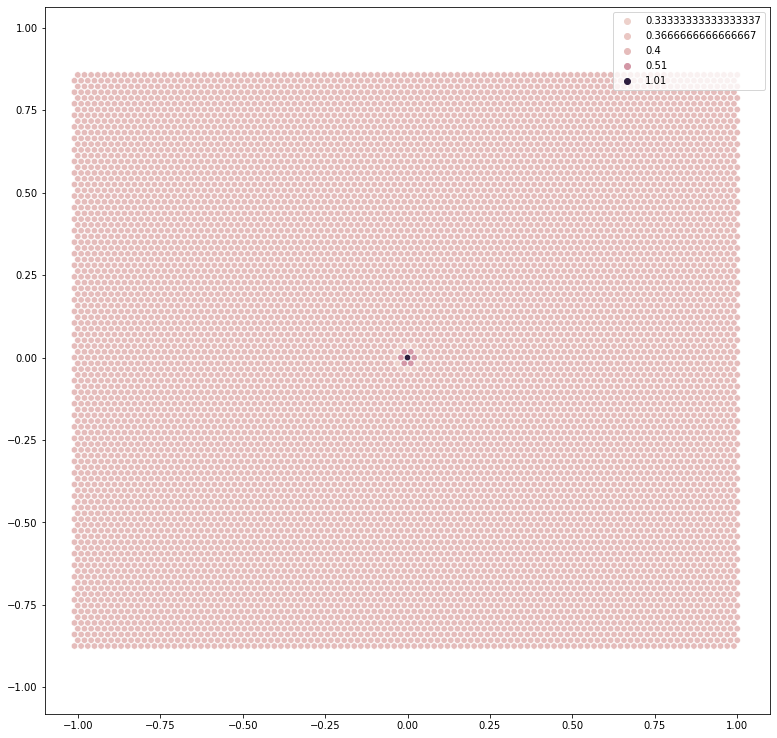

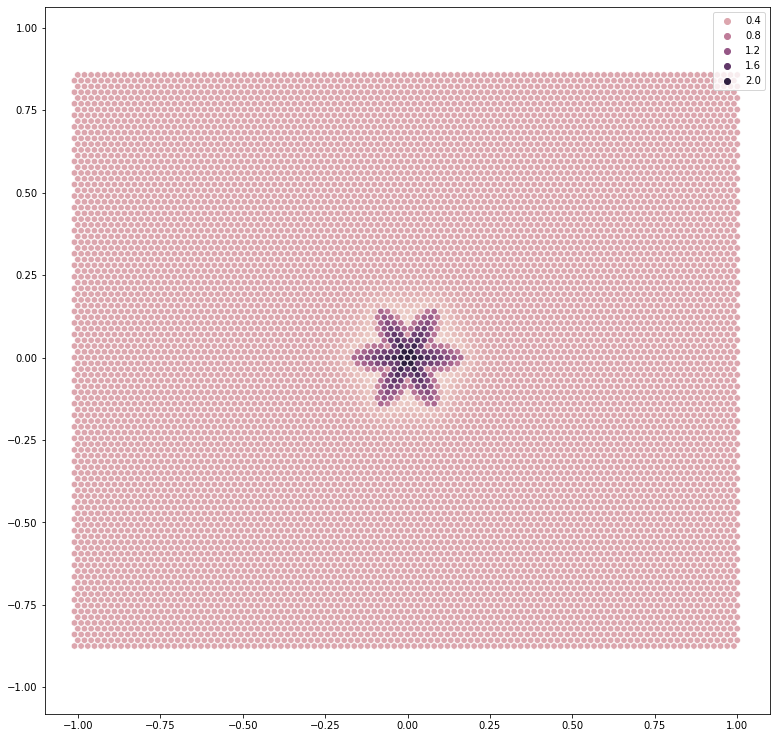

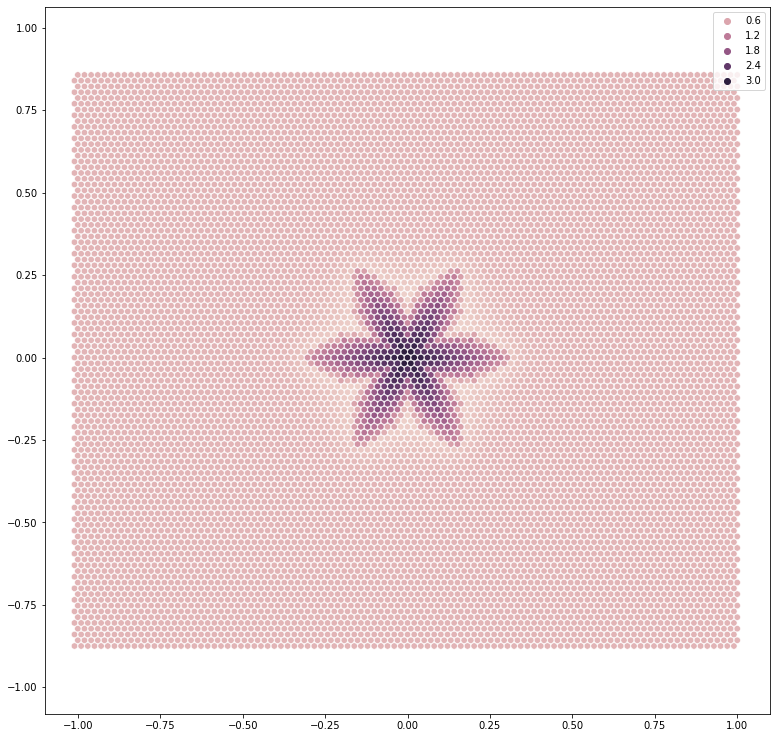

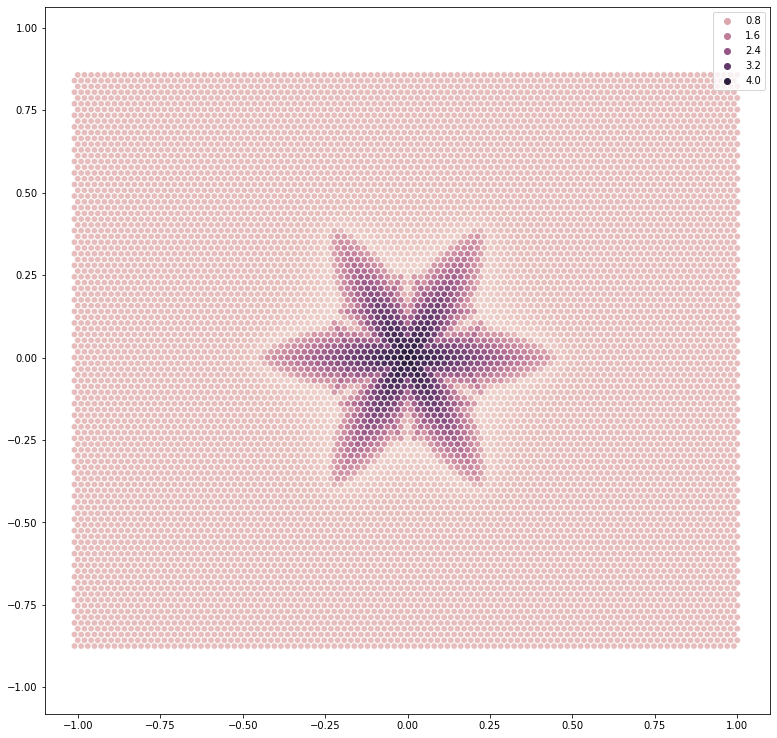

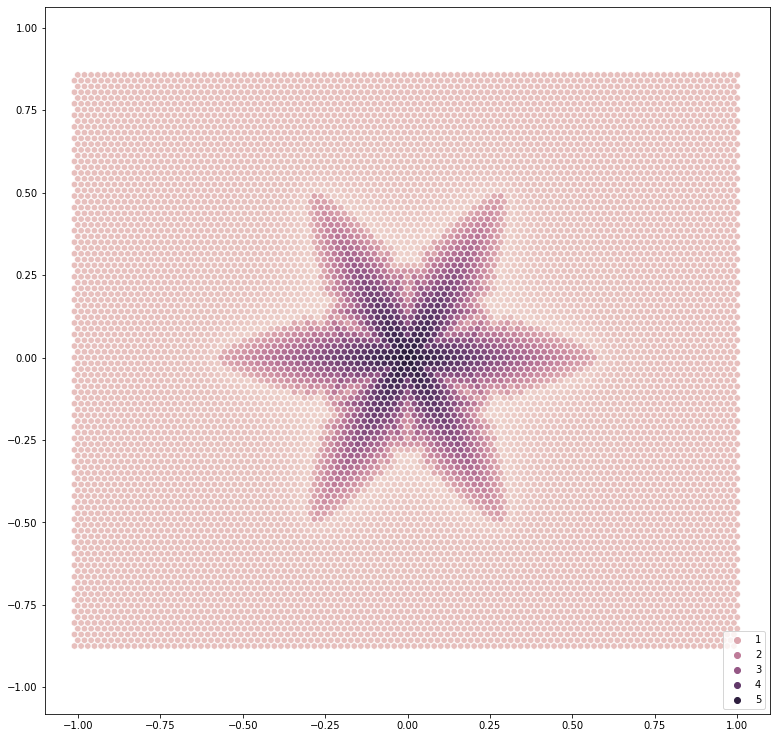

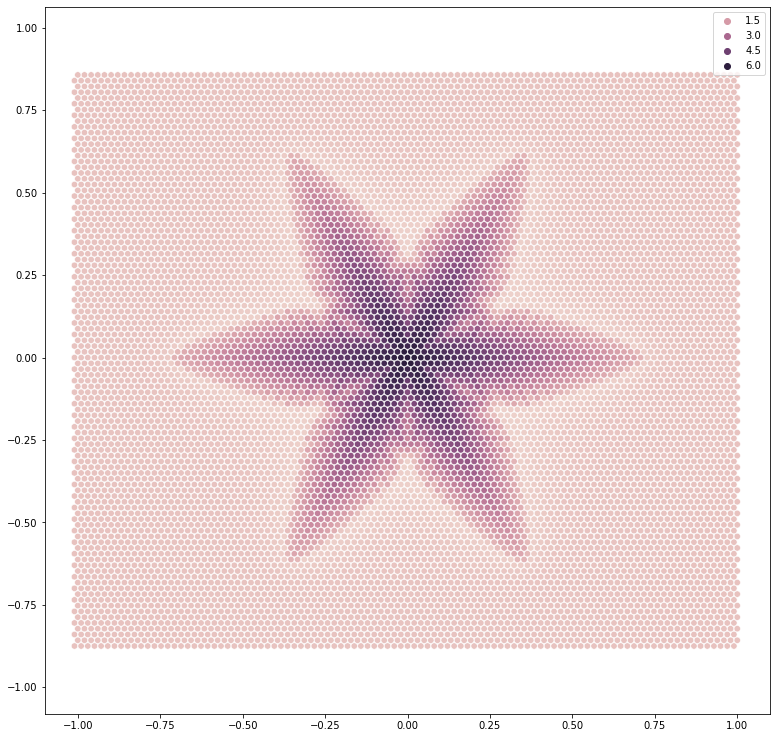

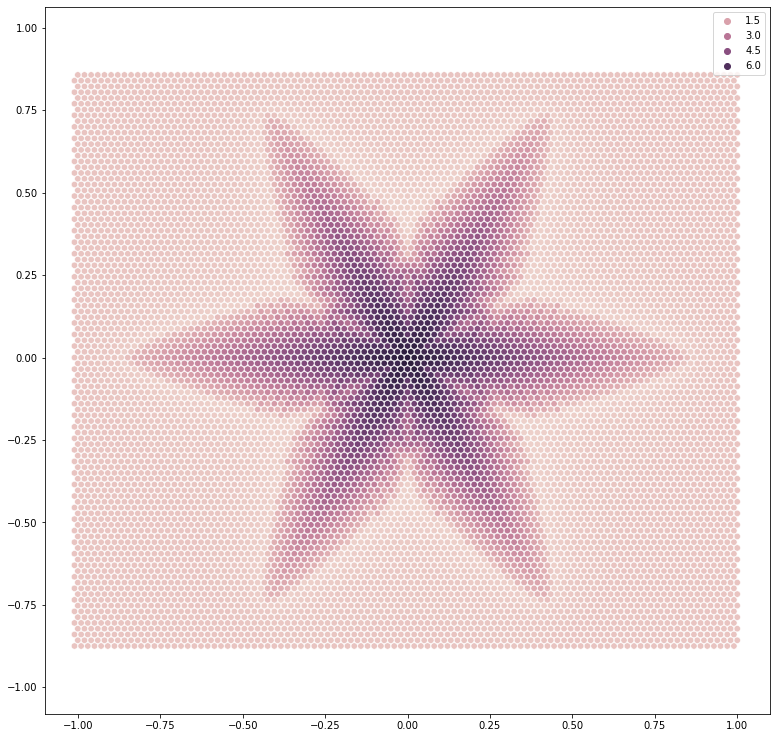

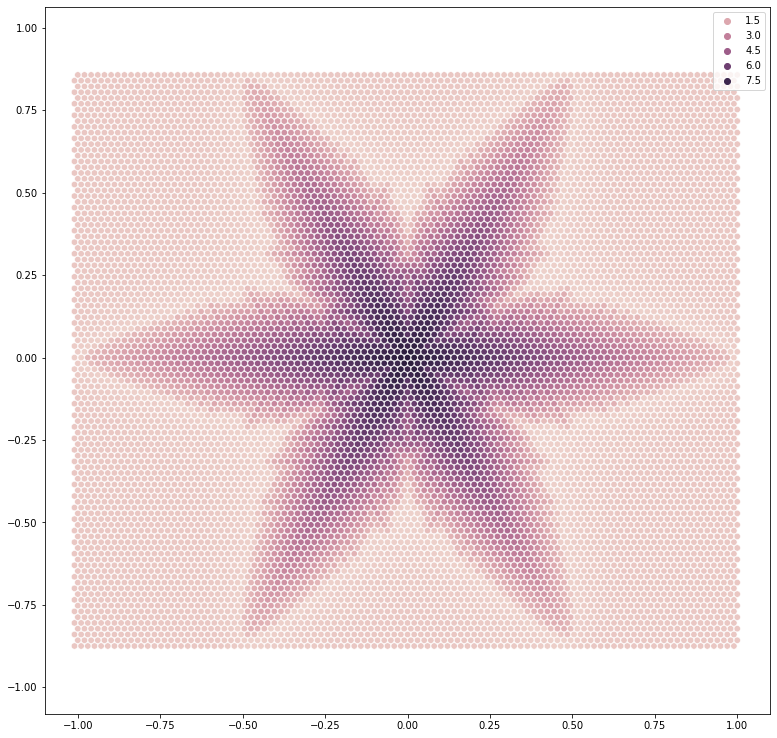

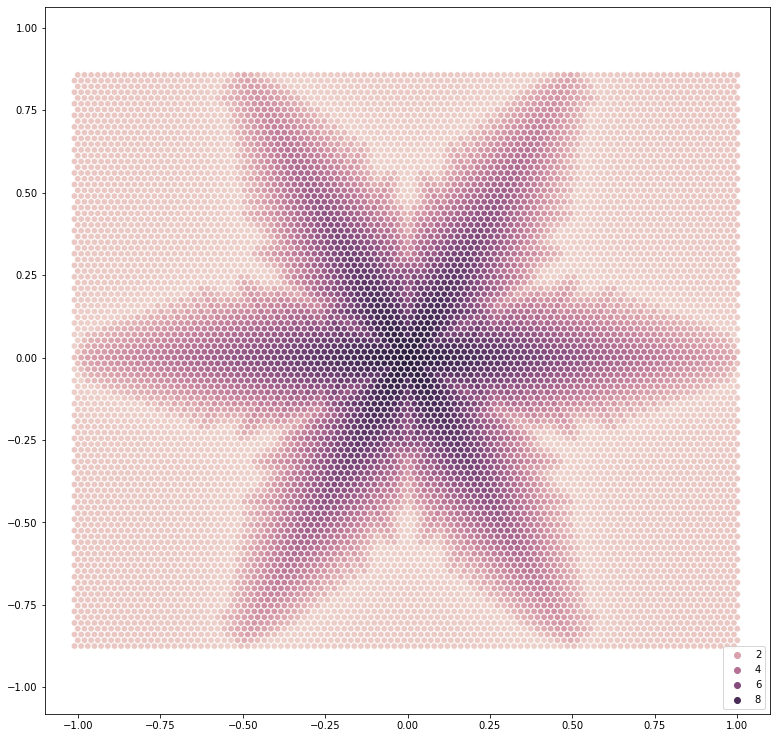

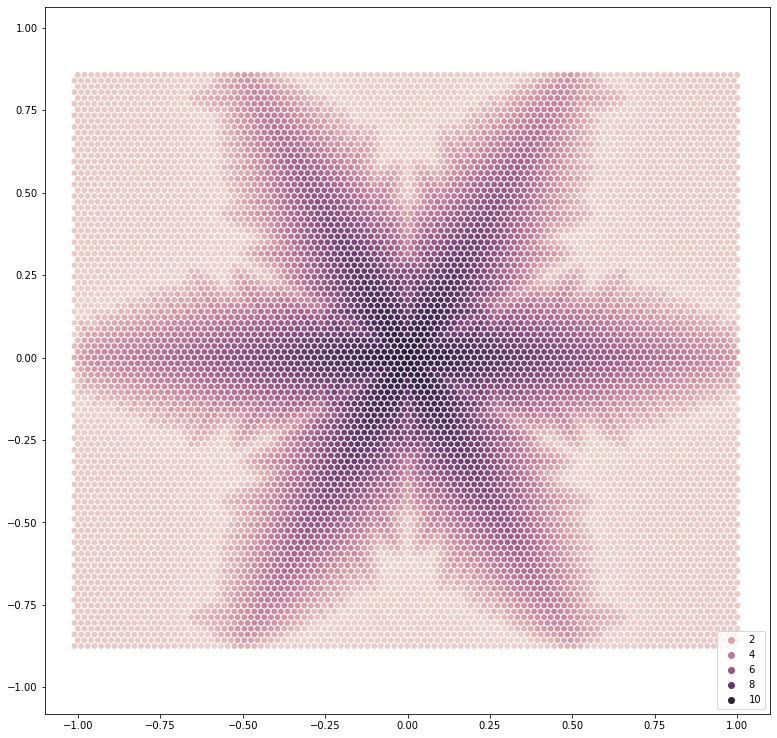

In [6]:
# control
tctr = 100
frame = 1

# simulation
for t in range(1000):
    
    # update Receptive region
    for c in cells:
        c.isIce = c.isI()
    for c in cells:
        c.isReceptive = c.isR()
    
    # time step
    for c in cells:
        c.u_new = c.diffuse() + c.grow(gamma)
    
    # assign
    for c in cells:
        c.u = c.u_new
    
    if t % tctr == 0:
        show(X, Y, cells)
#         plt.savefig('figs/%02d.png' % (frame))
#         with open('data/%02d.npy' % (frame), 'wb') as f:
#             np.save(f, X)
#             np.save(f, Y)
#             np.save(f, getU(cells))
            
        frame = frame + 1